# 0.Import Everything needed

In [20]:
import numpy as np
import tkinter as tk
from tkinter import Tk, filedialog
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io
import xarray as xr
from tkinter.filedialog import askopenfilename, askopenfilenames
from matplotlib.ticker import MaxNLocator
import os
from scipy.optimize import curve_fit
%matplotlib widget

# allow multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

def heatmap_interactive(_x, _y, _data, _title, _cmap='jet', _symlog=False):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.5], height_ratios=[0.5, 1], hspace=0.2, wspace=0.2)
    ax_main = plt.subplot(gs[1, 0])
    main_plot = ax_main.pcolormesh(_x, _y, _data, cmap=_cmap)
    ax_main.set(xlabel='Delay / ps', ylabel='Wavelength / nm')
    # set mixed log-lin scale with threshold value linthresh
    if _symlog:
        ax_main.set_xscale('symlog', linthresh=0.01)
    # set axis range to min and max values
    ax_main.set_xlim(_x[0],_x[-1])
    ax_main.set_ylim(_y[0],_y[-1]) 

    ax_kin = plt.subplot(gs[0, 0])
    line_kin, = ax_kin.plot(_x,np.zeros(_x.shape))
    kin_zero_line, = ax_kin.plot([_x[0],_x[-1]],[0,0], color="0.6")
    ax_kin.set_xlim(_x[0],_x[-1])
    if _symlog:
        ax_kin.set_xscale('symlog', linthresh=0.01)

    ax_spec = plt.subplot(gs[1, 1])
    line_spec, = ax_spec.plot(np.zeros(_y.shape),_y)
    spec_zero_line, = ax_spec.plot([0,0],[_y[0],_y[-1]], color="0.6")
    ax_spec.set_ylim(_y[0],_y[-1])        
    
    # This lower bounds list is necessary because the blocks in the 2D-plot cover a certain range
    def create_lower_bounds(_value_list):
        result = np.empty_like(_value_list)
        #first lower bound is equal to the lowest value in the nm-list
        result[0] = _value_list[0]
        #example: lower bound for 100 ps is 97.5 ps if the value prior is 95 ps, and 75 ps if the value prior is 50 ps.
        for i in range(1,len(_value_list)):
            result[i] = (_value_list[i]+_value_list[i-1])/2
        return result    
    
    nm_lower_bounds = create_lower_bounds(_y)
    time_lower_bounds = create_lower_bounds(_x)
    
    def nm_to_index(_nm):
        return np.where(_nm > nm_lower_bounds)[0][-1]
    
    def time_to_index(_time):
        return np.where(_time > time_lower_bounds)[0][-1]
    
    def mouse_move(event):
        x = event.xdata
        y = event.ydata
        if x is not None and y is not None:
            if x>=_x[0] and x<=_x[-1] and y>=_y[0] and y<=_y[-1]:
                # update spectra slice and rescale
                new_spec = _data[:,time_to_index(x)]
                line_spec.set_xdata(new_spec)
                spec_bounds = ax_spec.get_ylim()
                spec_range = new_spec[(_y>=spec_bounds[0]) & (_y<=spec_bounds[1])].max()-new_spec[(_y>=spec_bounds[0]) & (_y<=spec_bounds[1])].min()
                ax_spec.set_xlim(new_spec[(_y>=spec_bounds[0]) & (_y<=spec_bounds[1])].min()-0.1*spec_range,new_spec[(_y>=spec_bounds[0]) & (_y<=spec_bounds[1])].max()+0.1*spec_range)            

                # update kinetic slice and rescale
                new_kin = _data[nm_to_index(y),:]
                line_kin.set_ydata(new_kin)
                kin_bounds = ax_kin.get_xlim()  
                kin_range = new_kin[(_x>=kin_bounds[0]) & (_x<=kin_bounds[1])].max()-new_kin[(_x>=kin_bounds[0]) & (_x<=kin_bounds[1])].min()                
                ax_kin.set_ylim(new_kin[(_x>=kin_bounds[0]) & (_x<=kin_bounds[1])].min()-0.1*kin_range,new_kin[(_x>=kin_bounds[0]) & (_x<=kin_bounds[1])].max()+0.1*kin_range)
                
                # redraw figure
                fig.canvas.draw_idle()
             
    fig.canvas.mpl_connect('motion_notify_event', mouse_move) 
    
    # find max absolute value of 2D data in the specified zoom mode of the plot
    def get_maxvalue(_xlim, _ylim, _xvals, _yvals, _data_array):
        y_filter = (_yvals>=_ylim[0]) & (_yvals<=_ylim[1])
        x_filter = (_xvals>=_xlim[0]) & (_xvals<=_xlim[1])
        
        if not np.all(y_filter == False) and not np.all(x_filter == False):
            return np.amax(np.abs(_data_array[y_filter][:,x_filter]))
        else:
            return 0
    
    def on_xlims_change(event_ax):
        ax_kin.set_xlim(event_ax.get_xlim())
        
        new_max = get_maxvalue(event_ax.get_xlim(),event_ax.get_ylim(),_x,_y,_data)
        if new_max > 0:
            main_plot.set_clim(vmin=-new_max, vmax=new_max)

    def on_ylims_change(event_ax):
        ax_spec.set_ylim(event_ax.get_ylim())
        
        new_max = get_maxvalue(event_ax.get_xlim(),event_ax.get_ylim(),_x,_y,_data)
        if new_max > 0:
            main_plot.set_clim(vmin=-new_max, vmax=new_max)        

    ax_main.callbacks.connect('xlim_changed', on_xlims_change)
    ax_main.callbacks.connect('ylim_changed', on_ylims_change)
    plt.show(block=False)

    
def lin(x,a,b):
    return a*x+b

# 1. Import data .txt files 

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Pixels)')

Text(0, 0.5, 'Wavelength (nm)')

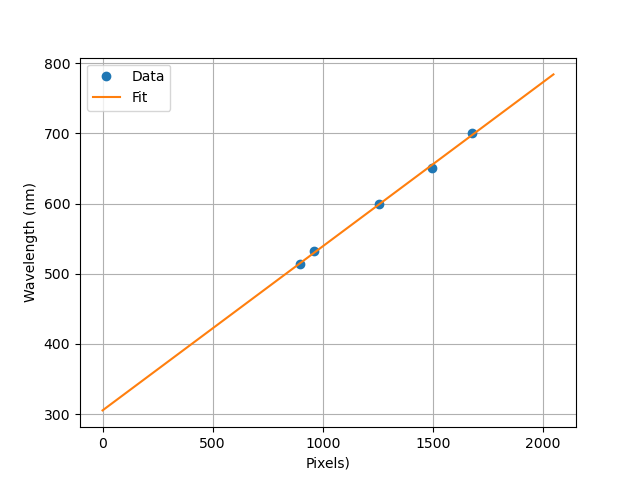

y = 0.23393504710716825x + 305.1436457862895


In [21]:
#Wavelength Calibaration
pixels = np.arange(0, 2048)
pixels_calibation = [898, 962, 1255,1495,1675] #Enter the values of your pixel calibration
wv_calibation = [514, 532, 600,650,700] #Enter the corresponding wl 

calibration,_ = curve_fit(lin,pixels_calibation,wv_calibation, method= "dogbox")
Fit_calibration = lin(pixels,*calibration)

plt.figure()
plt.plot(pixels_calibation,wv_calibation,  'o', label='Data')
plt.plot(pixels,Fit_calibration, '-', label='Fit')
plt.xlabel('Pixels)')
plt.ylabel('Wavelength (nm)')
plt.legend()
plt.grid("On")
plt.show()
print(f"y = {calibration[0]}x + {calibration[1]}")

lambda_values = calibration[0] * pixels + calibration[1]

In [22]:
#Pump Wavelenght (in nm)
Pump = 400 

#Get time vector data file
time_file = askopenfilename(filetypes=[("Text files", "*.txt")], title="Select Time vector data")
time = np.loadtxt(time_file)
#time = time / 1000  # convert from fs to ps

# Get TA scan files
ta_scan_files = askopenfilenames(filetypes=[("Text files", "*.txt")], title="Select TA scan files")

if len(ta_scan_files) > 1:
    Full_Data = np.zeros((2048, len(time), len(ta_scan_files))) #Array that will contain all the 
    for n, file in enumerate(ta_scan_files):
        data = np.loadtxt(file)
        Full_Data[:, :, n] = data  # save data array to 3D array (lambda, time, scan)
    
    for ii in range(len(ta_scan_files)): #Flip the sign if pump scatter is not negative.
        for jj in range(len(time)):
            if Full_Data[Pump, jj, ii] > 0:
                Full_Data[:, jj, ii] *= -1

    scan = np.mean(Full_Data, axis=2)
    scan = scan - np.mean(scan[:,:5],axis=1)[:, np.newaxis] #Baseline correction 
else:
    scan = np.loadtxt(ta_scan_files[0])
# Now 'scan' contains the processed data

#Create an xarray to manipulate the data (much easier)
dataset = xr.Dataset(
    {
        "data": (["time","spectral",], np.transpose(scan))
    },
    coords={
        "time": time,
        "spectral": lambda_values
    }
)

# Print the dataset
print(dataset)

<xarray.Dataset>
Dimensions:   (time: 128, spectral: 2048)
Coordinates:
  * time      (time) float64 -10.0 -5.0 -1.0 -0.9 -0.8 ... 70.0 80.0 90.0 100.0
  * spectral  (spectral) float64 305.1 305.4 305.6 305.8 ... 783.5 783.8 784.0
Data variables:
    data      (time, spectral) float64 0.0004263 0.0005598 ... -0.01921 -0.01758


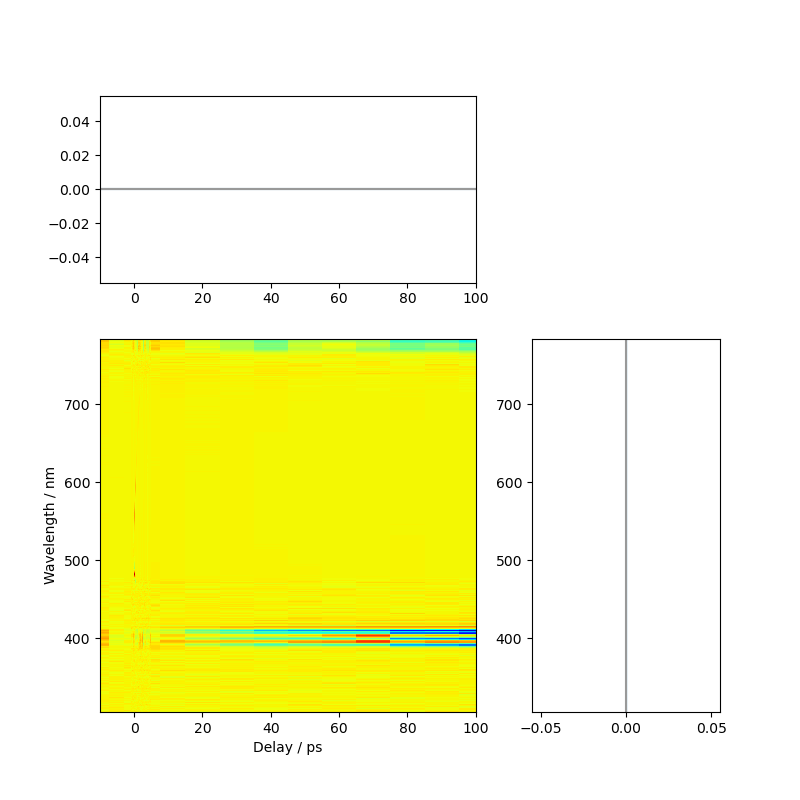

In [23]:
heatmap_interactive(time, lambda_values, scan,'Averaged scan plot',_symlog=False)

# 2. Create the .ana file

In [24]:
# Define the filename
filename = 'solventTHF.ana'

# Open the file for writing
with open(filename, 'w') as f:
    # Write the header
    f.write("%FILENAME={}\n".format(filename))
    f.write("%DATATYPE=TAVIS\n")
    f.write("%NUMBERSCANS=1\n")
    f.write("%TIMESCALE=ps\n")

    # Write the time list
    f.write("%TIMELIST={}\n".format("  ".join(map(str, dataset.time.values))))
    
    # Write the wavelength list
    f.write("%WAVELENGTHLIST={}\n".format("  ".join(map(str, dataset.spectral.values))))
    
    # Write the intensity matrix
    intensity_matrix = dataset.data.values  # Get the intensity values
    i = 0
    for row in intensity_matrix:
        if i == 0:
            f.write("%INTENSITYMATRIX={}\n".format("  ".join(map(str, row))))
            i = i+1
        else:
            f.write("{}\n".format("  ".join(map(str, row))))

print(f"File '{filename}' has been created successfully.")

25

16

15

14

753

39099

48467

49281

49395

48490

48265

48469

48373

48862

48238

48949

48667

49114

49417

48349

49052

48585

47963

48806

49255

49041

48193

48813

48855

48238

49047

48617

48833

48106

48175

48612

47809

48186

48161

48584

48093

48711

48070

48554

48676

48416

47808

48445

48281

48678

48552

48430

48035

48363

48359

48255

48666

48192

48242

48685

48312

48727

48019

48668

48100

48007

48168

48606

48481

48792

48089

48205

48600

48973

48544

49161

48256

48437

48639

48807

48723

48286

49053

48802

49137

48996

47839

49049

49205

47962

48838

49121

49153

49257

48786

49218

47972

49377

48509

48230

48465

48542

49329

47989

48378

48150

49410

48805

47814

47898

49313

49006

49199

48750

49210

49055

48254

49150

48565

49060

48176

48556

48093

48162

47871

49013

48004

48598

49059

49344

48957

48483

49132

49237

File 'solventTHF.ana' has been created successfully.
